In [6]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt


In [7]:
train_dir = '/dogs-vs-cats/train'
test_dir = 'f:/dogs-vs-cats/test1'
img_size = 50
LR = 1e-3

In [8]:
os.listdir('dogs-vs-cats')

['sampleSubmission.csv', 'test1', 'test1.zip', 'train', 'train.zip']

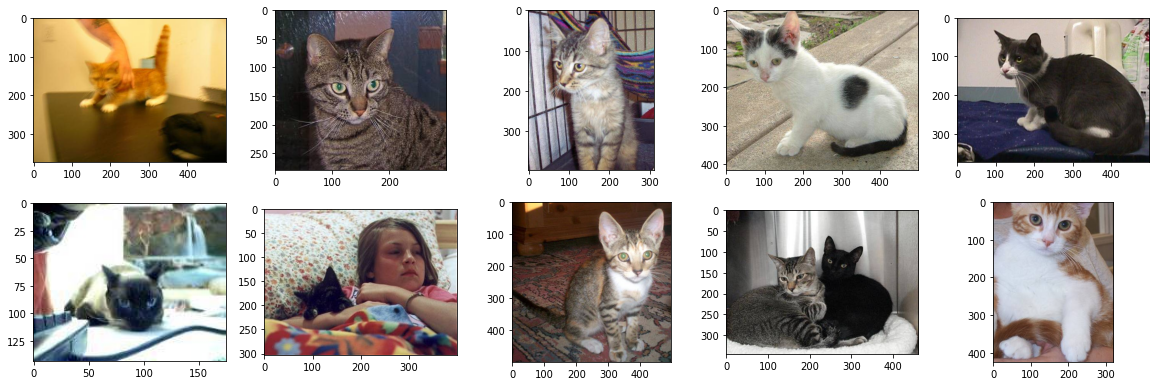

In [9]:
plt.figure(figsize=(20,10))
columns = 5
for i in range(10):
    image = plt.imread(os.path.join(train_dir, 'cat.{}.jpg'.format(str(i))))
    plt.subplot(int(10 / columns) + 1, columns, i + 1)
    plt.imshow(image)

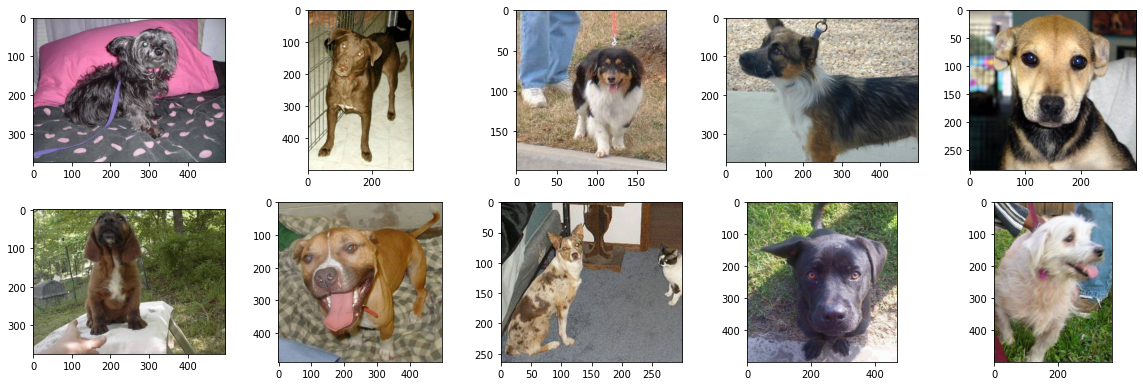

In [10]:
plt.figure(figsize=(20,10))
columns = 5
for i in range(10):
    image = plt.imread(os.path.join(train_dir, 'dog.{}.jpg'.format(str(i))))
    plt.subplot(int(10 / columns) + 1, columns, i + 1)
    plt.imshow(image)

In [11]:
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat':
        return [1, 0]
    elif word_label == 'dog':
        return [0, 1]

In [22]:
#img = cv2.resize(cv2.imread(os.path.join(train_dir, 'dog.{}.jpg'.format(str(0))), cv2.IMREAD_GRAYSCALE), (img_size, img_size))
#q = np.array(img)

In [12]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(train_dir)):
        label = label_img(img)
        path = os.path.join(train_dir, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size, img_size))
        img = img/255
        training_data.append([np.array(img, dtype = object), np.array(label, dtype=object)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [13]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(test_dir)):
        path = os.path.join(test_dir, img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size, img_size))
        img = img/255
        testing_data.append([np.array(img, dtype = object), img_num])
    
    np.save('test_data.npy', testing_data)
    return testing_data

In [23]:
train_data = create_train_data()
#if training data is already existing then load
#train_data = np.load('train_data.npy')

100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [04:13<00:00, 98.73it/s]


In [37]:
import tensorflow as tf
tf.compat.v1.reset_default_graph()
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression



convnet = input_data(shape=[None, img_size, img_size, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir = 'log')


In [38]:
train = train_data[:-500]
test = train_data[-500:]

In [39]:
X = np.array([i[0] for i in train], dtype = object).reshape(-1, img_size, img_size,1) 
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test], dtype = object).reshape(-1, img_size, img_size, 1)
test_y = [i[1] for i in test]


In [40]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id='DogvsCat')

Training Step: 1914  | total loss: 0.31394 | time: 59.122s
| Adam | epoch: 005 | loss: 0.31394 - acc: 0.8634 -- iter: 24448/24500
Training Step: 1915  | total loss: 0.31429 | time: 60.290s
| Adam | epoch: 005 | loss: 0.31429 - acc: 0.8584 | val_loss: 0.56345 - val_acc: 0.7500 -- iter: 24500/24500
--


In [44]:
test_data = process_test_data()

100%|████████████████████████████████████████████████████████████████████████████| 12500/12500 [03:19<00:00, 62.69it/s]
F:\anaconda3\envs\tf\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


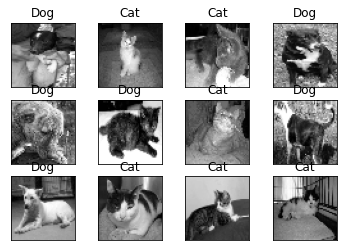

In [46]:
fig = plt.figure()
for num, data in enumerate(test_data[:12]):
    img_num  = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(-1,img_size, img_size, 1)
    
    model_out = model.predict([data[0]])
    
    if np.argmax(model_out) == 1:
        str_label = 'Dog'
    else:
        str_label = 'Cat'
        
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()